# **Section 1 Project**


---


**Topic : 다음 분기에 어떤 게임을 설계해야 할까**


---



필수 요소
> 1. 지역별 선호 게임 장르의 차이점 유무
> 2. 연도별 게임의 트렌드 유무
> 3. 인기가 많은 게임에 대한 분석 및 시각화 프로세스

Feature
>  - Name : 게임의 이름
>  - Platform : 게임이 지원되는 플랫폼의 이름
>  - Year : 게임 출시 연도
>  - Genre : 게임 장르
>  - Publisher : 게임 배급 회사
>  - NA_Sales : 북미지역 출고량
>  - EU_Sales : 유럽지역 출고량
>  - JP_Sales : 일본지역 출고량
>  - Other_Sales : 기타지역 출고량



In [ ]:
import pandas as pd
import numpy as np

!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 데이터셋 불러오기 
df = pd.read_csv('vgames2.csv')

# 불필요한 컬럼 제거
df = df.drop(['Unnamed: 0'], axis=1)

# 결측치 Drop
df = df.dropna(axis = 0)

# Year 전처리
df['Year'] = df['Year'].astype(int)
## 2자리인 year 값들 4자리로 변환
def year(x):
  if (x >= 0) & (x < 20):
    return int(2000 + x)
  elif (x > 30) & (x < 1000):
    return int(1900 + x)
  else:
    return int(x)

df['Year'] = df['Year'].apply(year)

## 데이터가 적은 Year Drop
df = df.drop(df[df['Year']==2017].index)
df = df.drop(df[df['Year']==2020].index)

# Sales 컬럼들 전처리 
## 기본 단위가 M(백만)로 지정, 숫자만 남게 변환
def change (df):
  df_copy = df
  if 'K' in df_copy:
    #df_copy.replace('K', '')
    df_copy = float(df_copy.replace('K', ''))
    return df_copy/1000
  elif 'M' in df_copy:
    #df_copy.replace('M','')
    df_copy = float(df_copy.replace('M',''))
    return df_copy
  else:
    return float(df_copy)

df['NA_Sales'] = df.NA_Sales.apply(change)
df['EU_Sales'] = df.EU_Sales.apply(change)
df['JP_Sales'] = df.JP_Sales.apply(change)
df['Other_Sales'] = df.Other_Sales.apply(change)    
## 'Total_Sales'컬럼을 생성해서 전체 출고량 저장
df['Total_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']

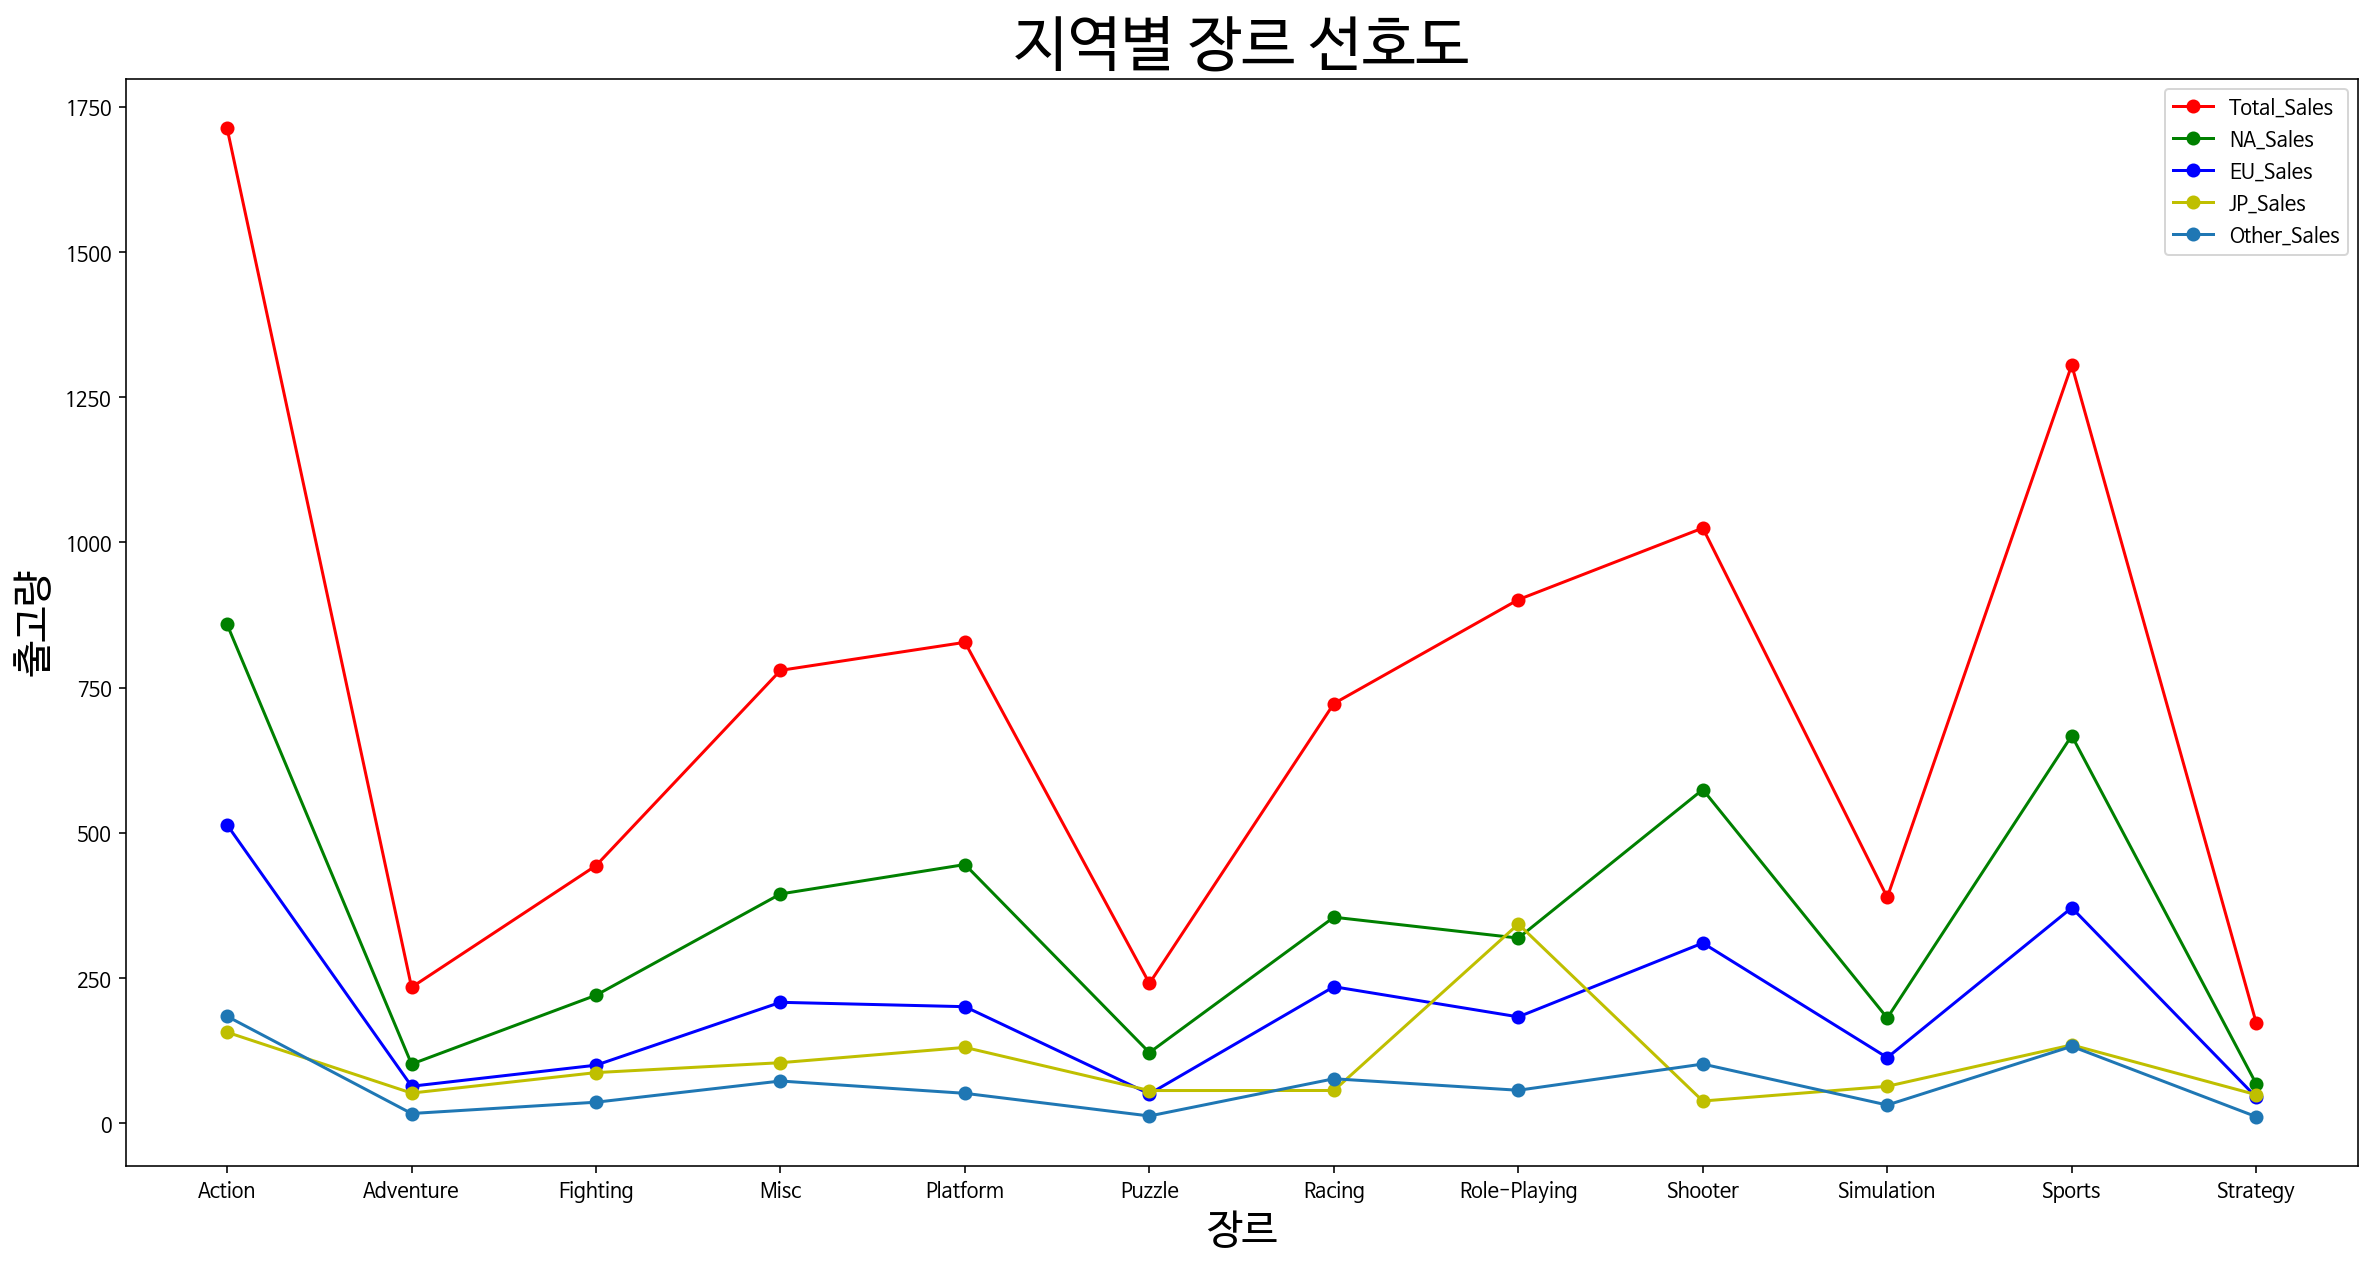

In [ ]:
# 지역별 선호하는 장르
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

df_genre_total = df.groupby(by=['Genre'])['Total_Sales'].sum() # 전 지역 선호하는 게임 장르
df_genre_total = df_genre_total.reset_index()
plt.plot(df_genre_total['Genre'], df_genre_total['Total_Sales'],marker='o',label = 'Total_Sales', color='r')

df_genre_na = df.groupby(by=['Genre'])['NA_Sales'].sum() # 북미 선호하는 게임 장르
df_genre_na = df_genre_na.reset_index()
plt.plot(df_genre_na['Genre'], df_genre_na['NA_Sales'],marker='o',label = 'NA_Sales', color = 'g')

df_genre_eu = df.groupby(by=['Genre'])['EU_Sales'].sum() # 유럽 선호하는 게임 장르
df_genre_eu = df_genre_eu.reset_index()
plt.plot(df_genre_eu['Genre'], df_genre_eu['EU_Sales'],marker='o',label = 'EU_Sales', color = 'b')

df_genre_jp = df.groupby(by=['Genre'])['JP_Sales'].sum() # 일본 선호하는 게임 장르
df_genre_jp = df_genre_jp.reset_index()
plt.plot(df_genre_jp['Genre'], df_genre_jp['JP_Sales'],marker='o',label = 'JP_Sales', color = 'y')

df_genre_ot = df.groupby(by=['Genre'])['Other_Sales'].sum() # 그외 지역 선호하는 게임 장르
df_genre_ot = df_genre_ot.reset_index()
plt.plot(df_genre_ot['Genre'], df_genre_ot['Other_Sales'],marker='o',label = 'Other_Sales')
plt.legend()

plt.title("지역별 장르 선호도", fontsize=30)
plt.xlabel("장르", fontsize=20)
plt.ylabel("출고량", fontsize=20)


plt.show()

In [ ]:
# 가설검정을 위해 데이터프레임 준비
df_genre = df_genre_na.combine_first(df_genre_eu).combine_first(df_genre_jp).combine_first(df_genre_ot)
df_genre = df_genre.set_index('Genre')
df_genre

,EU_Sales,JP_Sales,NA_Sales,Other_Sales
Genre,,,,
Action,513.64,156.59,858.75,183.99
Adventure,63.66,51.87,101.79,16.70
Fighting,99.90,87.14,220.35,36.15
Misc,208.15,104.18,394.73,72.64
Platform,200.63,130.53,445.38,51.45
Puzzle,50.47,56.24,121.58,12.44
Racing,235.02,56.32,354.70,76.51
Role-Playing,183.09,342.89,318.76,56.73
Shooter,310.23,38.18,574.48,101.86


In [ ]:
from scipy.stats import chi2_contingency

# 일본의 경우 그래프를 육안으로 확인해봐도 선호도 그래프의 형태가 다름
# 일본을 제외하고 나머지 3지역에 대해 가설검정을 실시
# 카이제곱 검정으로 판단, 두개의 변수가 서로 연관성이 있는지를 검정한다.
# 귀무가설 : 지역마다 선호하는 장르가 같거나 비슷하다
# 대립가설 : 지역마다 선호하는 장르가 다르다

df_Genre_drop_jp = df_genre.drop(['JP_Sales'], axis=1)
chi2_val, p, dof, expected= chi2_contingency(df_Genre_drop_jp, correction=False)
if(p<0.05) : 
    print('p value:', p,"\n"+'귀무가설을 기각한다. 지역마다 선호하는 장르가 다르다.')
else :
    print('p value:', p,"\n"+'귀무가설을 기각하지 못한다. 지역마다 선호하는 장르가 같거나 비슷하다.')

p value: 0.024080297712670187 
귀무가설을 기각한다. 지역마다 선호하는 장르가 다르다.


In [ ]:

# 연도별 가장 많이 출시된 장르 (공급)

# 연도별 장르 갯수 추출
df_year_genre = df.groupby(['Year', 'Genre']).size().reset_index(name='Count')
# 최댓값 추출
year_genre_bool = df_year_genre.groupby(['Year'])['Count'].transform(max) == df_year_genre['Count']
year_max_genre = df_year_genre[year_genre_bool].reset_index(drop=True)
# 중복값 제거
year_max_genre = year_max_genre.drop_duplicates(subset=['Year','Count']).reset_index(drop=True)
year_max_genre.rename(index = {'Count': 'Sales'}, inplace = True)
year_max_genre

,Year,Genre,Count
0,1980,Misc,4
1,1981,Action,25
2,1982,Action,18
3,1983,Action,7
4,1984,Puzzle,3
5,1985,Platform,4
6,1986,Action,6
7,1987,Sports,4
8,1988,Platform,4
9,1989,Puzzle,5


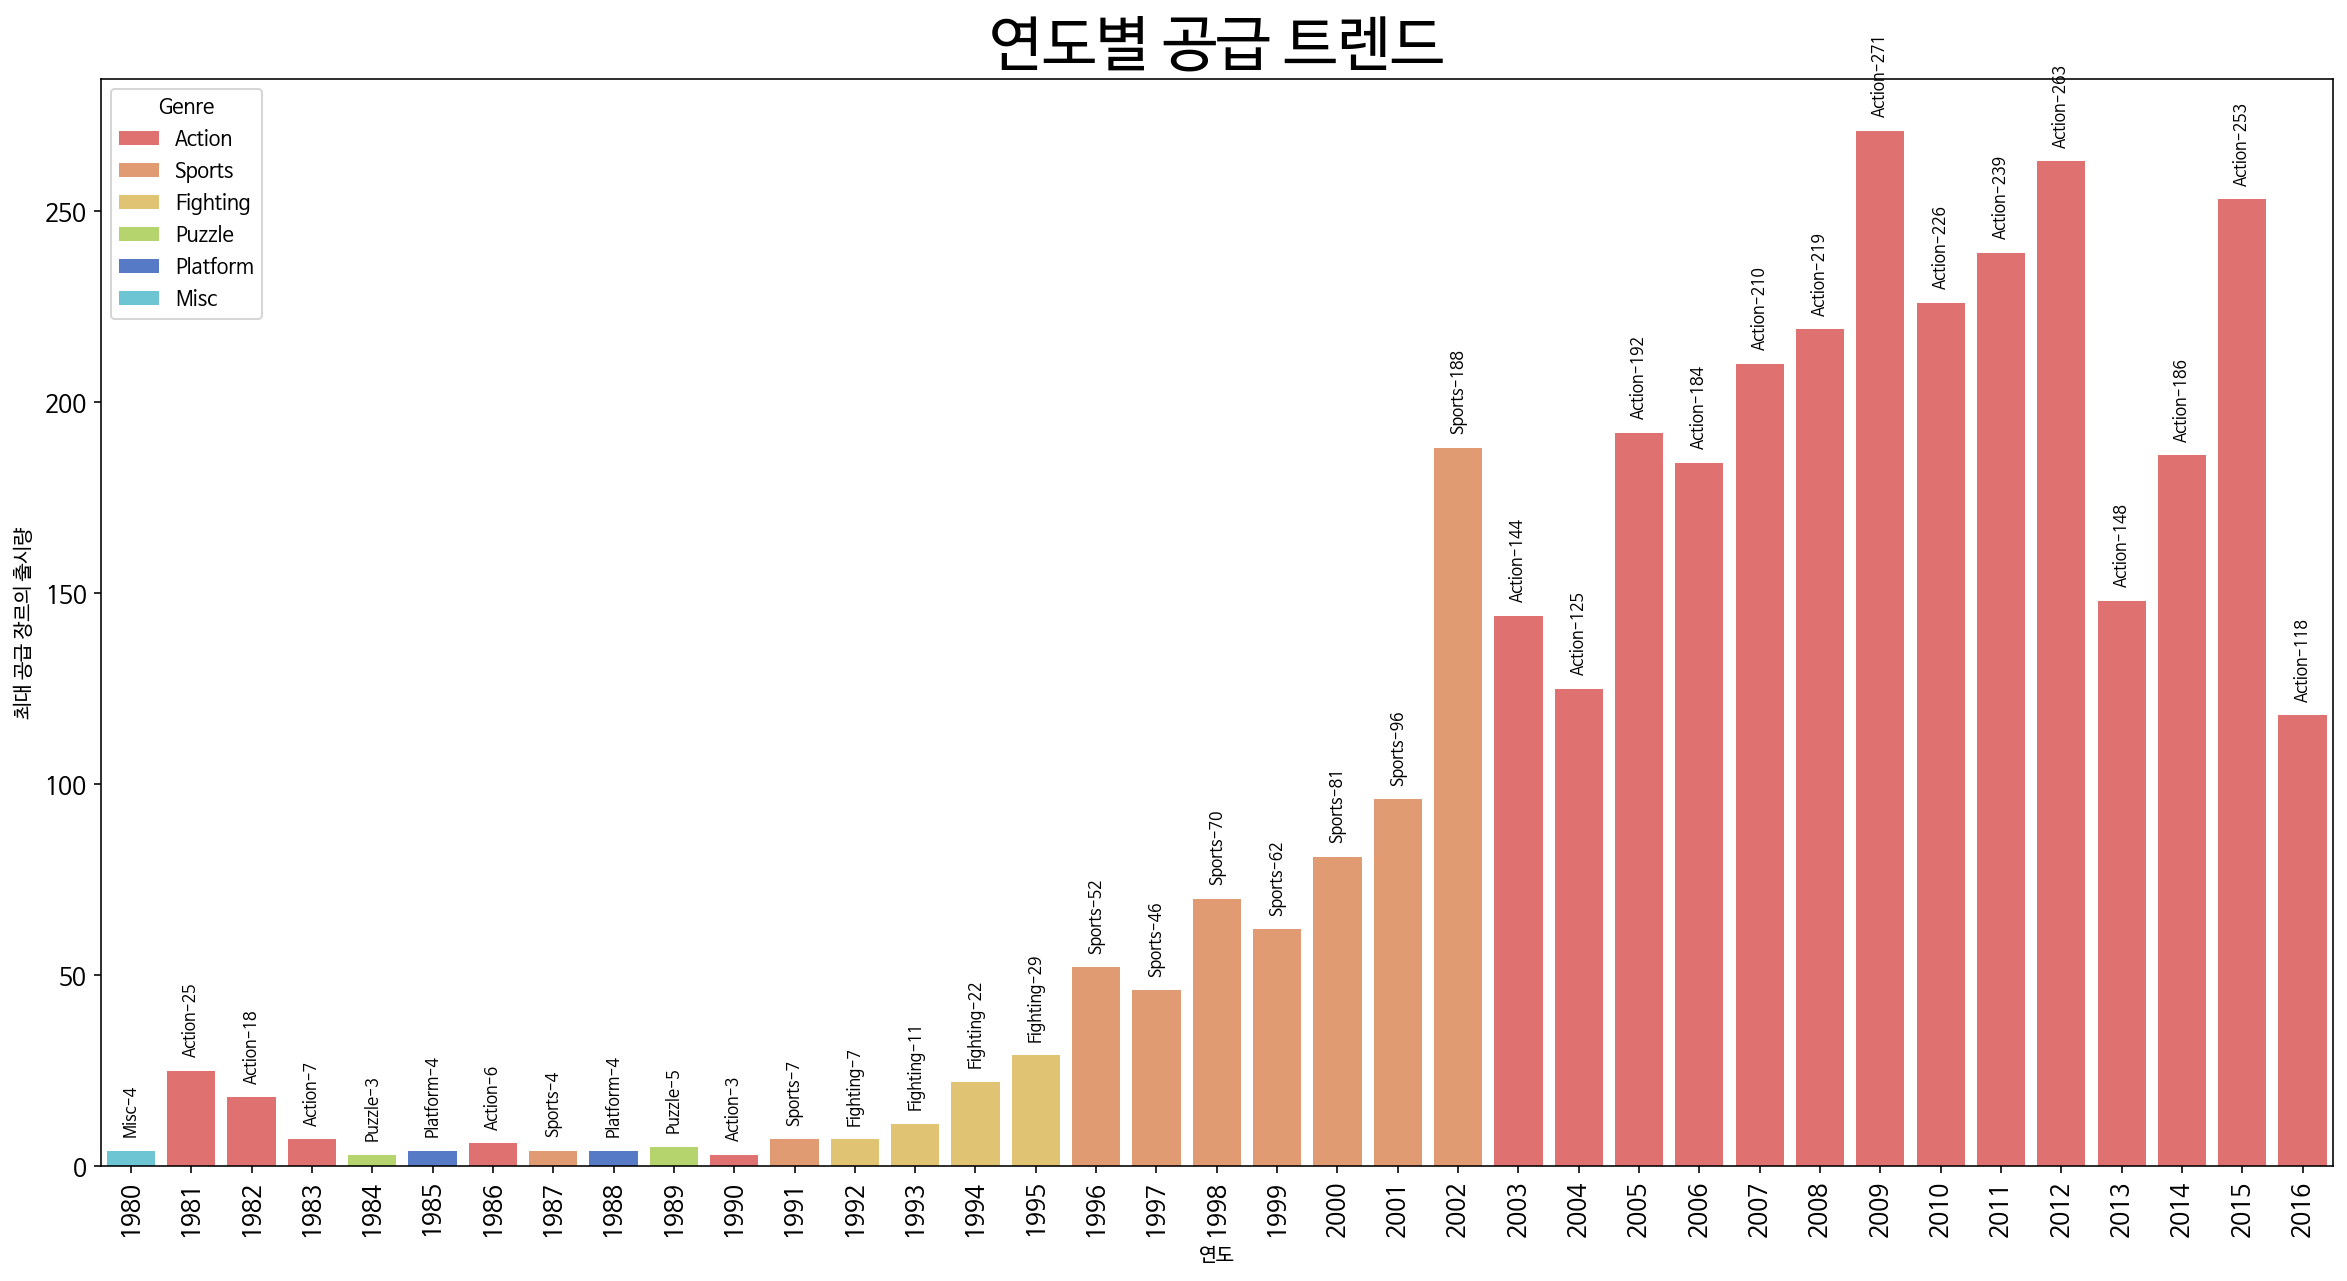

In [ ]:
# 연도별 공급 트렌드 그래프
import numpy as np, scipy.stats as st
genre = year_max_genre['Genre'].values
plt.figure(figsize=(20,10))

colors = ["#F15F5F"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Count',hue='Genre', data=year_max_genre,hue_order=['Action'])
colors = ["#F29661"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Count',hue='Genre', data=year_max_genre,hue_order=['Sports'])
colors = ["#F2CB61"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Count',hue='Genre', data=year_max_genre,hue_order=['Fighting'])
colors = ["#BCE55C"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Count',hue='Genre', data=year_max_genre,hue_order=['Puzzle'])
colors = ["#4374D9"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Count',hue='Genre', data=year_max_genre,hue_order=['Platform'])
colors = ["#5CD1E5"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Count',hue='Genre', data=year_max_genre,hue_order=['Misc'])
colors = ["#6799FF"]


cnt = 0
for value in year_max_genre['Count']:
    year_barplot.text(x=cnt, y=value + 5, s=str(genre[cnt] + '-' + str(value)),
            color='black', size=8, rotation=90, ha='center')
    cnt+=1
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.title('연도별 공급 트렌드', fontsize = 30)
plt.xlabel('연도')
plt.ylabel('최대 공급 장르의 출시량')
plt.show()
# 공급 부분에서 최근 트렌드는 Action 장르임을 알 수 있다.

In [ ]:

# 연도별 가장 많이 출고(판매)된 장르 (수요)

# 연도별 장르 총매출 추출
year_max_sales = df.groupby(['Year', 'Genre'])['Total_Sales'].sum().reset_index()
# 최댓값 추출
year_sales_bool = year_max_sales.groupby(['Year'])['Total_Sales'].transform(max) == year_max_sales['Total_Sales']
year_max_sales = year_max_sales[year_sales_bool].reset_index(drop=True)
year_max_sales

,Year,Genre,Total_Sales
0,1980,Shooter,7.07
1,1981,Action,14.79
2,1982,Puzzle,10.04
3,1983,Platform,6.93
4,1984,Shooter,31.10
5,1985,Platform,43.17
6,1986,Action,13.74
7,1987,Fighting,5.42
8,1988,Platform,27.73
9,1989,Puzzle,37.75


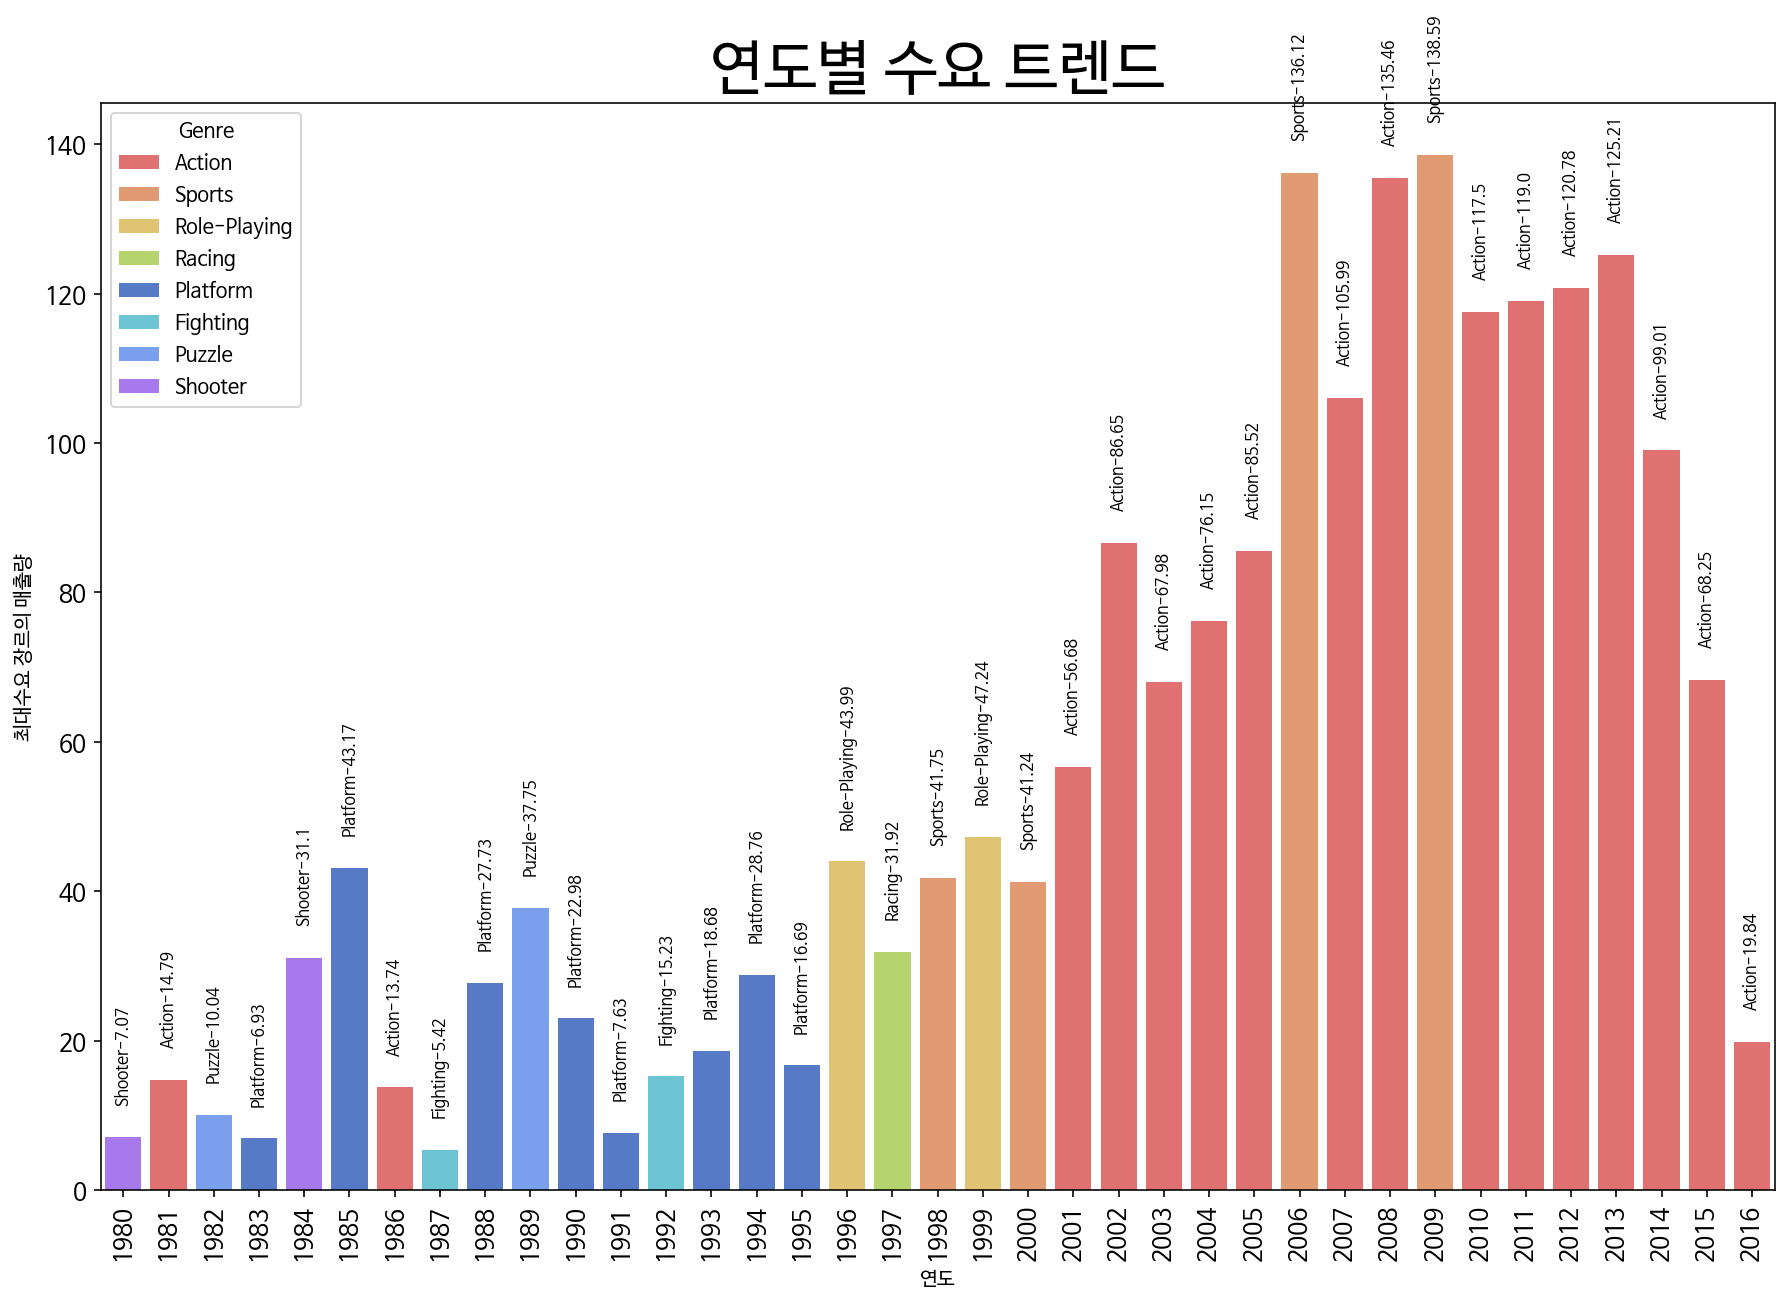

In [ ]:
# 연도별 수요 트렌드 그래프
genre = year_max_sales['Genre'].values
plt.figure(figsize=(15,10))

colors = ["#F15F5F"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Total_Sales',hue='Genre', data=year_max_sales,hue_order=['Action'])
colors = ["#F29661"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Total_Sales',hue='Genre', data=year_max_sales,hue_order=['Sports'])
colors = ["#F2CB61"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Total_Sales',hue='Genre', data=year_max_sales,hue_order=['Role-Playing'])
colors = ["#BCE55C"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Total_Sales',hue='Genre', data=year_max_sales,hue_order=['Racing'])
colors = ["#4374D9"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Total_Sales',hue='Genre', data=year_max_sales,hue_order=['Platform'])
colors = ["#5CD1E5"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Total_Sales',hue='Genre', data=year_max_sales,hue_order=['Fighting'])
colors = ["#6799FF"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Total_Sales',hue='Genre', data=year_max_sales,hue_order=['Puzzle'])
colors = ["#A566FF"]
sns.set_palette(sns.color_palette(colors))
year_barplot = sns.barplot(x='Year', y='Total_Sales',hue='Genre', data=year_max_sales,hue_order=['Shooter'])


cnt = 0
for value in year_max_sales['Total_Sales']:
    year_barplot.text(x=cnt, y=value + 5, s=str(genre[cnt] + '-' + str(round(value,2))),
            color='black', size=8, rotation=90, ha='center')
    cnt+=1
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.title('연도별 수요 트렌드', fontsize=30)
plt.xlabel('연도')
plt.ylabel('최대수요 장르의 매출량')
plt.show()
# 수요 부분에서 최근 트렌드는 Action 장르임을 알 수 있다.

In [ ]:
# 출고량이 높은 게임에 대한 분석 및 시각화 프로세스
# 2012년도 이후 총판매량 Top 100을 선정
sales_top100 = df[df.Year > 2012].sort_values(by='Total_Sales' ,ascending=False)
sales_top100 = sales_top100.head(100).reset_index(drop=True)
sales_top100

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
1,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
3,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,3.80,5.81,0.36,2.02,11.99
4,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,Nintendo,4.23,3.37,3.08,0.65,11.33
...,...,...,...,...,...,...,...,...,...,...
95,Minecraft,PSV,2014,Misc,Sony Computer Entertainment Europe,0.28,0.79,0.87,0.32,2.26
96,New Super Luigi U,WiiU,2013,Platform,Nintendo,1.27,0.62,0.18,0.16,2.23
97,Assassin's Creed IV: Black Flag,XOne,2013,Action,Ubisoft,1.47,0.55,0.00,0.19,2.21
98,Forza Motorsport 5,XOne,2013,Racing,Microsoft Game Studios,1.21,0.78,0.01,0.17,2.17


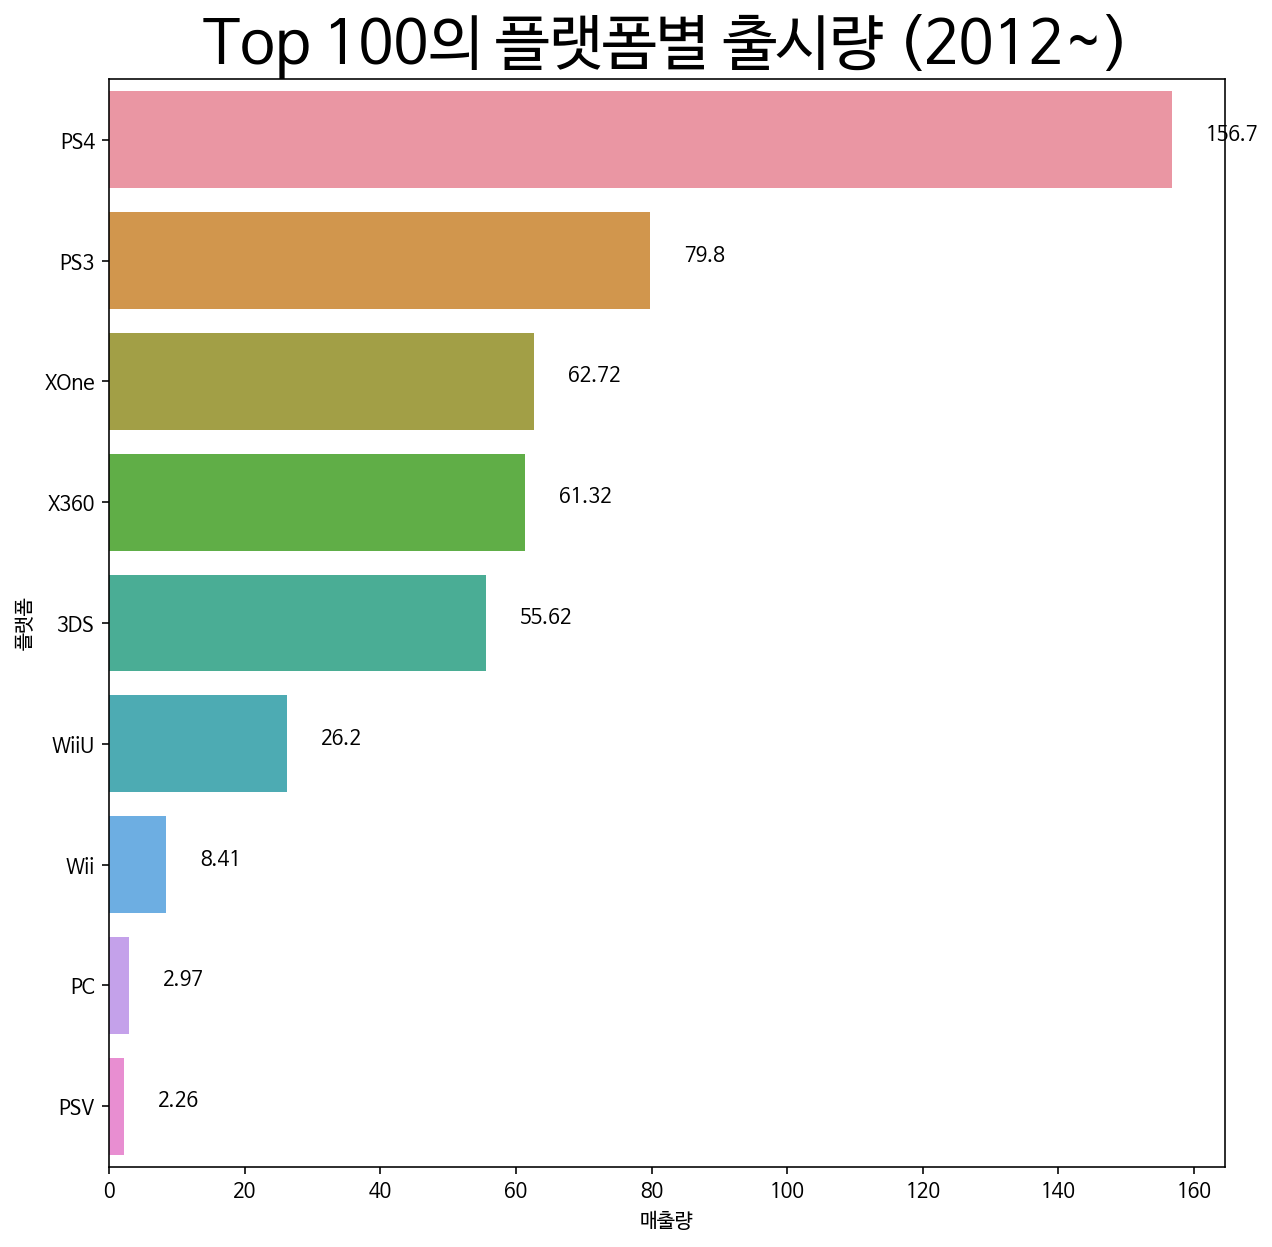

In [ ]:
# top100 Platform 그래프
top100_platform = sales_top100.groupby(['Platform'])['Total_Sales'].sum().reset_index()
top100_platform = top100_platform.sort_values(by='Total_Sales', ascending=False)
platform = top100_platform['Platform'].values
plt.figure(figsize=(10, 10))
top100_platform_sales = sns.barplot(x ='Total_Sales', y='Platform', data=top100_platform)
cnt = 0
for value in top100_platform['Total_Sales']:
    top100_platform_sales.text(x=value + 5, y=cnt, s=str(round(value,2)),
            color='black', size=10)
    cnt+=1
plt.title('Top 100의 플랫폼별 출시량 (2012~)', fontsize=30)
plt.xlabel('매출량')
plt.ylabel('플랫폼')
plt.show()
# 2012년 이후 출고량이 많았던 플랫폼은 PS3,PS4이다.

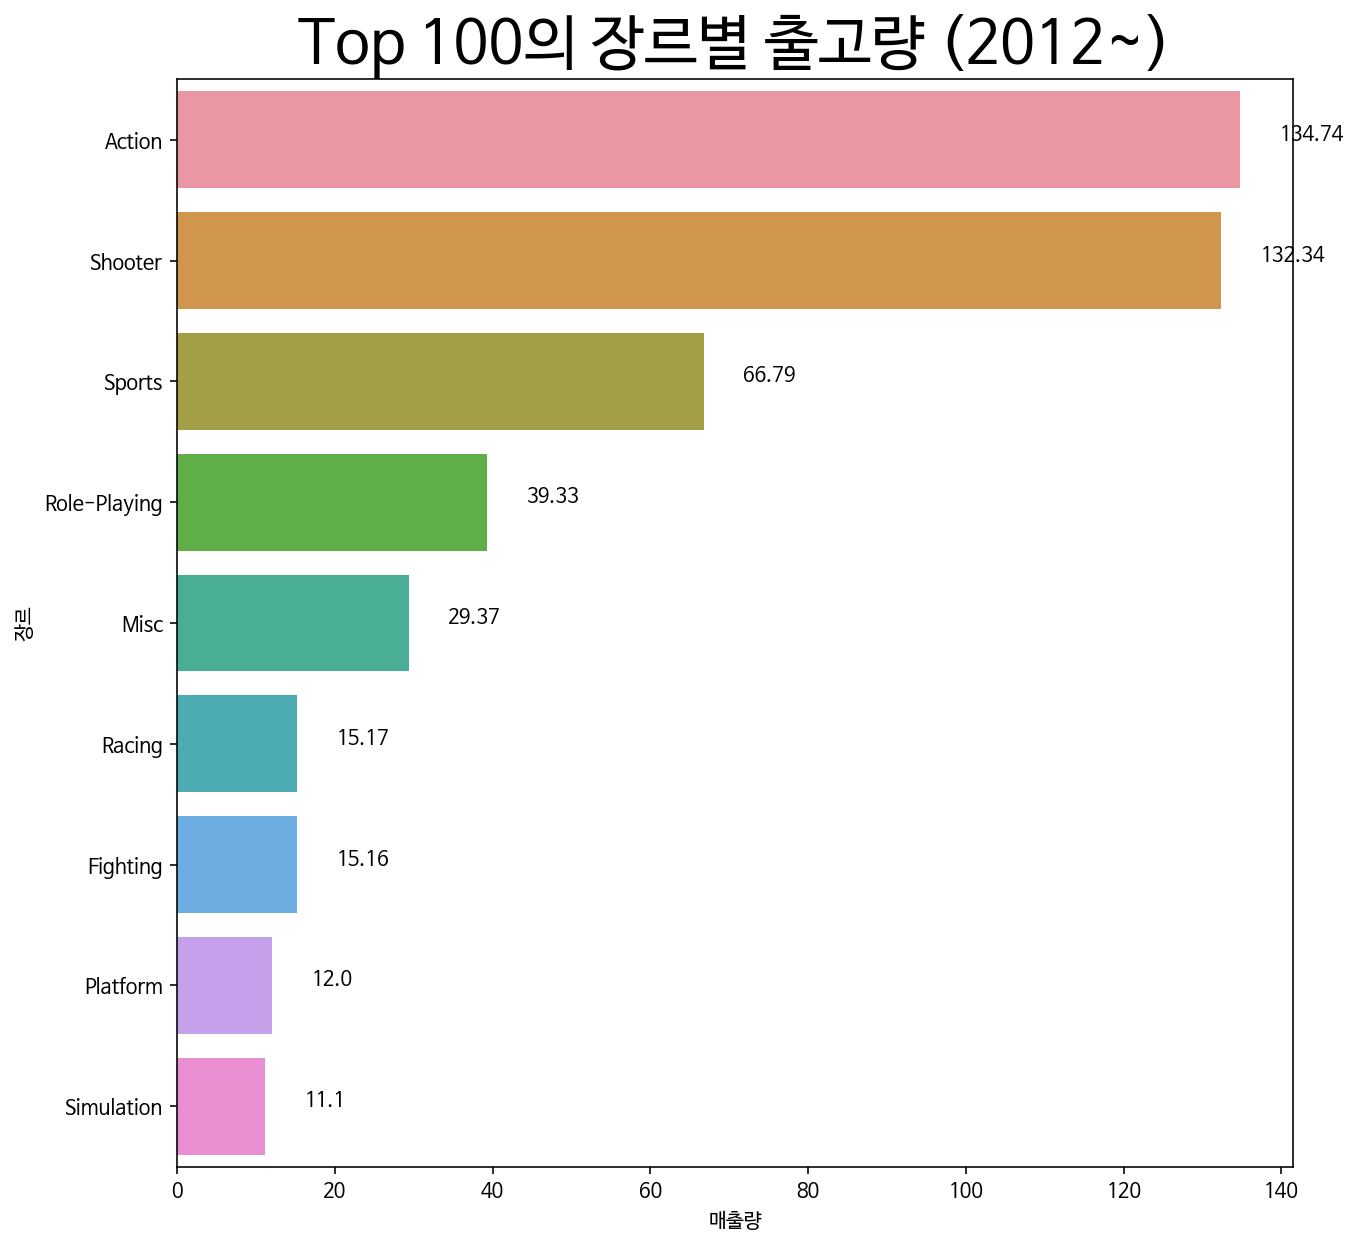

In [ ]:
# top100 Genre 그래프
top100_genre = sales_top100.groupby(['Genre'])['Total_Sales'].sum().reset_index()
top100_genre = top100_genre.sort_values(by='Total_Sales',ascending=False)
genre = top100_genre['Genre'].values
plt.figure(figsize=(10, 10))
top100_genre_sales = sns.barplot(x ='Total_Sales', y='Genre', data=top100_genre)
cnt = 0
for value in top100_genre['Total_Sales']:
    top100_genre_sales.text(x=value + 5, y=cnt, s=str(round(value,2)),
            color='black', size=10)
    cnt+=1
plt.title('Top 100의 장르별 출고량 (2012~)',fontsize=30)
plt.xlabel('매출량')
plt.ylabel('장르')
plt.show()
# 2012년 이후 출고량이 많았던 장르는 Action, Shooter 이다.

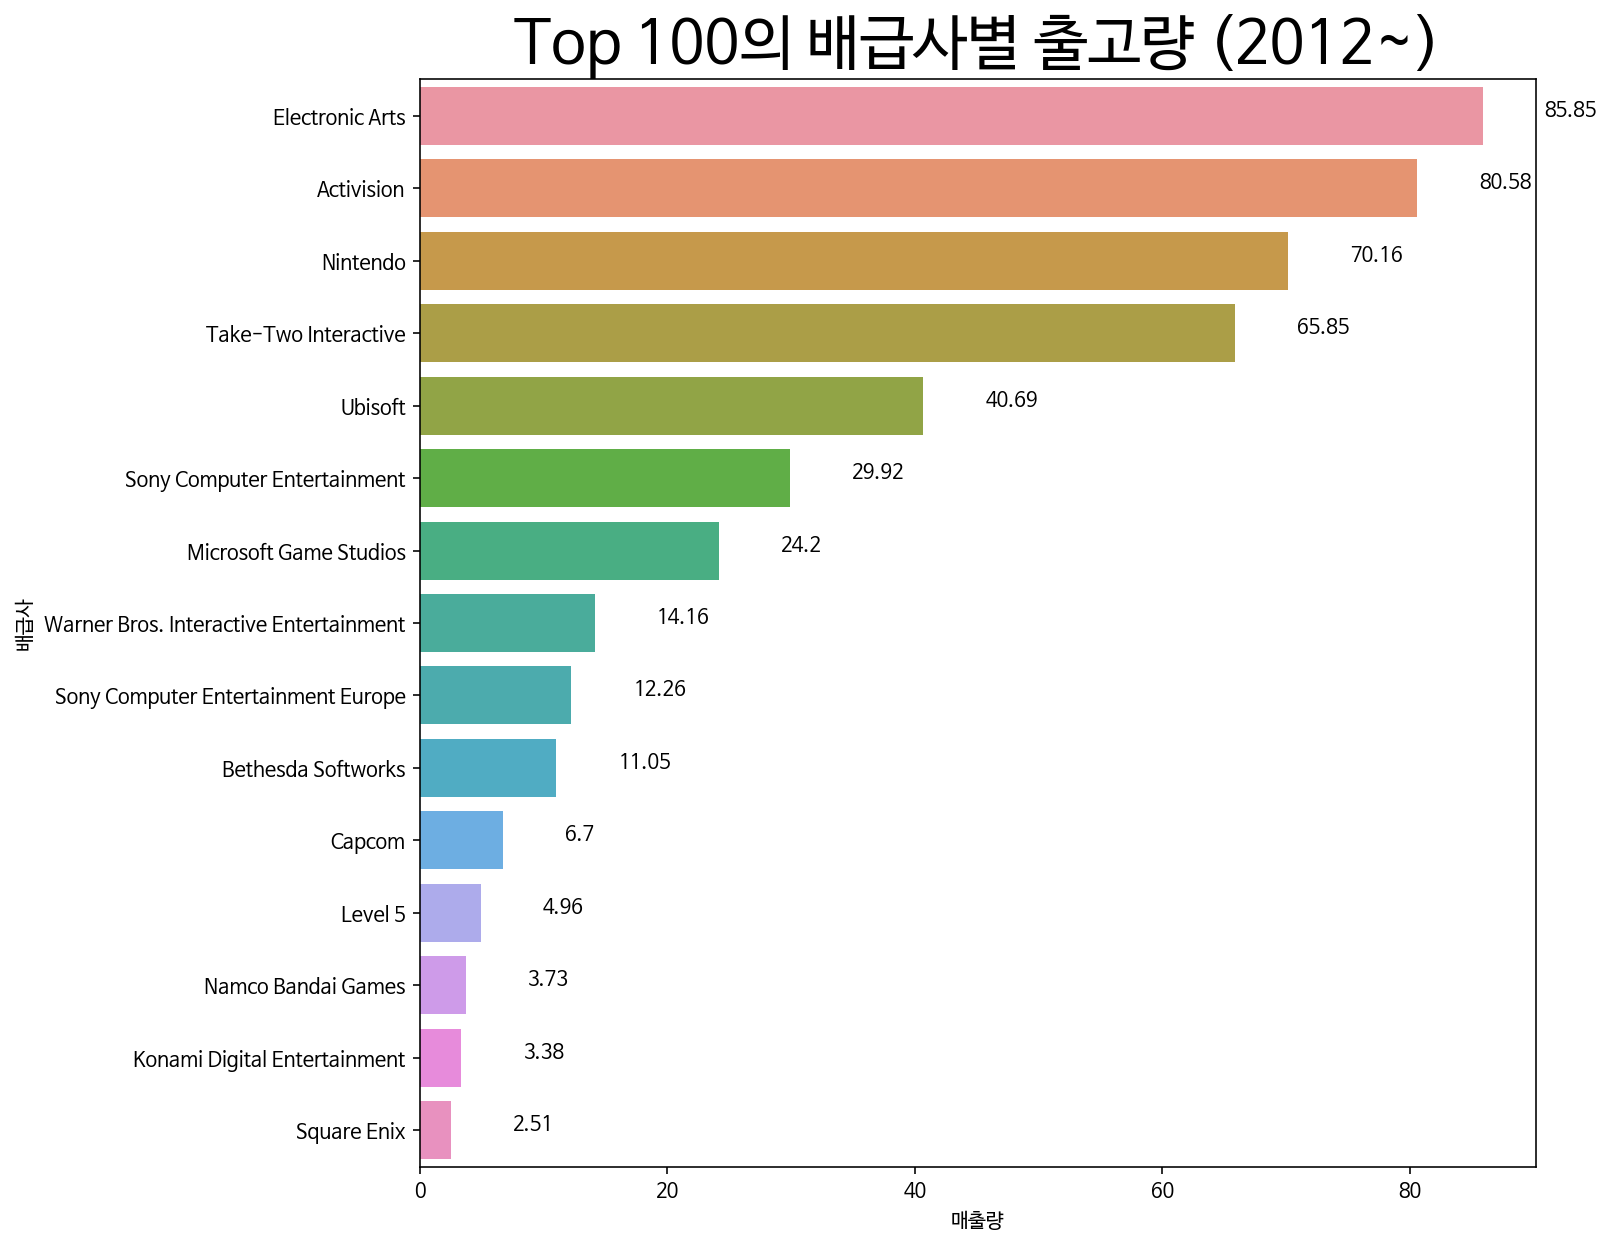

In [ ]:
# top100 Publisher 그래프
top100_publisher = sales_top100.groupby(['Publisher'])['Total_Sales'].sum().reset_index()
top100_publisher = top100_publisher.sort_values(by='Total_Sales' ,ascending=False)
publisher = top100_publisher['Publisher'].values
plt.figure(figsize=(10, 10))
top100_publisher_sales = sns.barplot(x ='Total_Sales', y='Publisher', data=top100_publisher)
cnt = 0
for value in top100_publisher['Total_Sales']:
    top100_publisher_sales.text(x=value + 5, y=cnt, s=str(round(value,2)),
            color='black', size=10)
    cnt+=1
plt.title('Top 100의 배급사별 출고량 (2012~)', fontsize=30)
plt.xlabel('매출량')
plt.ylabel('배급사')
plt.show()
# 2012년 이후 출고량이 많았던 회사는 Activision, Electronic Arts, Nintendo 이다.

In [ ]:
# 배급사별 총 출고량 순위
top100_publisher.reset_index(drop=True)

,Publisher,Total_Sales
0,Electronic Arts,85.85
1,Activision,80.58
2,Nintendo,70.16
3,Take-Two Interactive,65.85
4,Ubisoft,40.69
5,Sony Computer Entertainment,29.92
6,Microsoft Game Studios,24.20
7,Warner Bros. Interactive Entertainment,14.16
8,Sony Computer Entertainment Europe,12.26
9,Bethesda Softworks,11.05


In [ ]:
# 1게임당 출고량 순위
top100_publisher_name = sales_top100.groupby(['Publisher'])['Name'].size().reset_index(name='Count')
top100_publisher_name = top100_publisher.combine_first(top100_publisher_name)
top100_publisher_name = top100_publisher_name.set_index('Publisher')
top100_publisher_name['mean'] = round(top100_publisher_name['Total_Sales']/top100_publisher_name['Count'],2)
top100_publisher_name = top100_publisher_name.sort_values(by='mean' ,ascending=False)
top100_publisher_name


,Count,Total_Sales,mean
Publisher,,,
Take-Two Interactive,8,65.85,8.23
Activision,13,80.58,6.20
Bethesda Softworks,2,11.05,5.52
Nintendo,15,70.16,4.68
Electronic Arts,21,85.85,4.09
Sony Computer Entertainment Europe,3,12.26,4.09
Microsoft Game Studios,6,24.20,4.03
Sony Computer Entertainment,8,29.92,3.74
Namco Bandai Games,1,3.73,3.73


In [ ]:
# top100에서 다시 top10추출
sales_top100.head(10)


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
1,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
3,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,3.80,5.81,0.36,2.02,11.99
4,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,Nintendo,4.23,3.37,3.08,0.65,11.33
5,Call of Duty: Ghosts,X360,2013,Shooter,Activision,6.72,2.63,0.04,0.82,10.21
6,Call of Duty: Ghosts,PS3,2013,Shooter,Activision,4.09,3.73,0.38,1.38,9.58
7,Minecraft,X360,2013,Misc,Microsoft Game Studios,5.58,2.83,0.02,0.77,9.20
8,FIFA 16,PS4,2015,Sports,Electronic Arts,1.11,6.06,0.06,1.26,8.49
9,Star Wars Battlefront (2015),PS4,2015,Shooter,Electronic Arts,2.93,3.29,0.22,1.23,7.67


 # <인사이트>
> 시각화한 그래프와 표를 분석했을때 다음과 같은 결론을 내렸다.
>
> ### 1. 지역별 선호 장르 
>    그래프를 보면 일본의 경우 role-playing 장르가 높았고 
>    나머지 지역은 Action 장르를 선호했다. \
>    그러나 가장 많이 팔렸다고 해서 그 지역 사람들이 같은 선호도를 가졌다고  보기 어렵다고 판단, \
>일본을 제외한 세 지역을 기준으로 가설 검정을 실시
>    검정 결과 세 지역도 선호도가 다르다는 결론이 나왔다.
>
>
> ### 2. 트렌드 기준 : '얼마나 많이 출시했고 얼마나 많이 팔렸나' 
>
> - 공급과 수요 트렌드 분석\
>    2000년도 이전에는 데이터의 양은 적었으나 다양한 장르가 인기있었다.\
>    특히 소비자들은 2000년도 이전 다양한 장르에 관심이 있었다.\
>    그러나 2000년대로 넘어오면서 sport, \
>     2010년대에는 Action 장르가 독점하였다. 
>    과거에는 연도별 트렌드가 존재했으나 최근 20년간 특정 장르가 독점하였다. 
>    최신 트렌드는 'Action'이였다.
>   - 공급트렌드 = 배급사들이 출시한 장르의 개수 \
>       (배급사 기준 연도별 장르의 총 개수)
>   - 수요트렌드 = 소비자가 구매한 양 \
>       (장르 기준 연도별 출고량)
>
>
> ### 3. 분석 및 인사이트  
> - 지역마다 선호하는 장르의 비율이 다르다고는 하나 세 지역에서 가장 많이 팔린 장르가 'Action'이였고 일본 지역도 2위가 'Action'장르였다.
> - 공급과 수요 트렌드를 그래프로 시각화 해본 결과, 최근 10년간 연도별 트렌드는 존재하지 않았고 'Action' 장르가 많이 출시되고 그만큼 많이 팔렸음을 알 수 있었다.
> - 판매량을 분석하기 위해 2012년 이후 자료 중 판매량 top100을 추출하여 플랫폼, 장르, 배급사 별로 판매량을 그래프로 나타내었다. 
>  - 플랫폼의 경우 1,2위에 ps시리즈가 있었지만 3,4위의 xbox시리즈도 유의미한 매출량이 나왔다고 판단했다.
>  - 장르의 경우 'Action'이 1위로 나타났지만 2위의 'Shooter'장르도 비슷한 매출량을 기록했다.
>  - 배급사의 경우 순서대로 'Electronic Arts', 'Activision', 'Nintendo' 가 높은 매출량을 기록했지만 2012년 이후 출시한 게임의 수를 고려하여 1게임당 판매량을 다시 계산하였을때 'Take-Two Interactive' 배급사가 가장 높은 매출을 달성하였다. 총 매출이 높다고 해서 인기 있는 게임이 아니였고 앞서 3개의 회사는 자금과 인프라가 풍부하여 시장을 보다 공격적으로 공략하기 위해 많은 개수의 게임을 출시하였고 그것이 매출로 이어진 것으로 보인다. 따라서 'Take-Two Interactive' 회사의 게임이 인기가 많은것으로 판단했다. 이 회사는 플랫폼만 다를 뿐 같은 게임인 'Grand Theft Auto V'가 총 매출 상위 1,2,4위를 차지했고 해당 게임은 'Action'장르이다.
>
> ### 4. 결론
> - 여러가지 분석을 통해서 'Action'장르가 선호도 높음을 알 수 있었고 가장 인기 있는 게임인 'Grand Theft Auto V' 장르도 'Action'이였다. 플랫폼의 경우 ps시리즈가 강세를 보였지만 xbox시리즈도 유의미한 매출량을 보여주었다.
따라서 다음 분기에는 'Take-Two Interactive'사의 'Grand Theft Auto V'와 유사한 샌드박스형 action 장르의 게임을 멀티 플랫폼 형식으로 설계해야한다.
(샌드박스형 : 유저가 정해진 목표 없이 자유롭게 무언가를 할 수 있는 게임 플레이 형식 또는 장르)